In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Get the dataset
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  1949k      0  0:06:53  0:06:53 --:--:-- 2580k  0  0:31:52  0:00:03  0:31:49  421k00:19  0:08:05 1497k     0  0:06:56  0:02:58  0:03:58 1736k6:58  0:03:00  0:03:58 1541k  1899k      0  0:07:03  0:03:09  0:03:54 1163k  0:04:34  0:02:22 1475k     0  0:07:01  0:06:20  0:00:41 1178k


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

Cats_vs_Dogs_v2.ipynb       kagglecatsanddogs_3367a.zip
MSR-LA - 3467.docx          readme[1].txt
PetImages


In [4]:
!ls PetImages

Cat Dog


In [5]:
CAT_DIR = "PetImages/Cat"
DOG_DIR = "PetImages/Dog"


In [6]:
Cat_SIZE = len([name for name in os.listdir(CAT_DIR)])
Dog_SIZE = len([name for name in os.listdir(DOG_DIR)])
print("Number of Cat images:", Cat_SIZE)
print("Number of Dog images:", Dog_SIZE)

Number of Cat images: 12501
Number of Dog images: 12501


In [7]:
#filter out corrupted images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [8]:
#Generate a Dataset

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


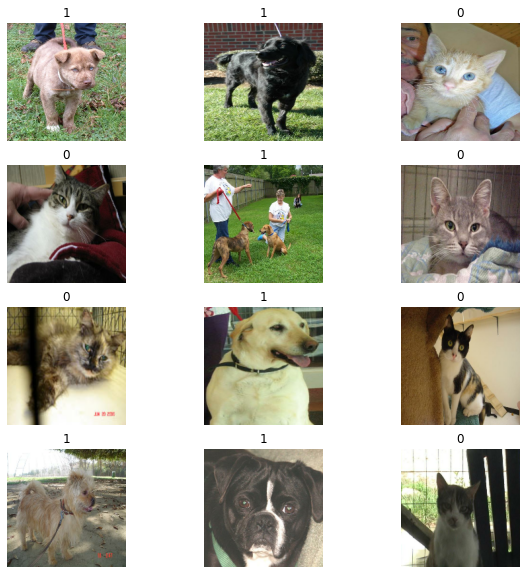

In [9]:
#Visualize the data
#Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat"

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

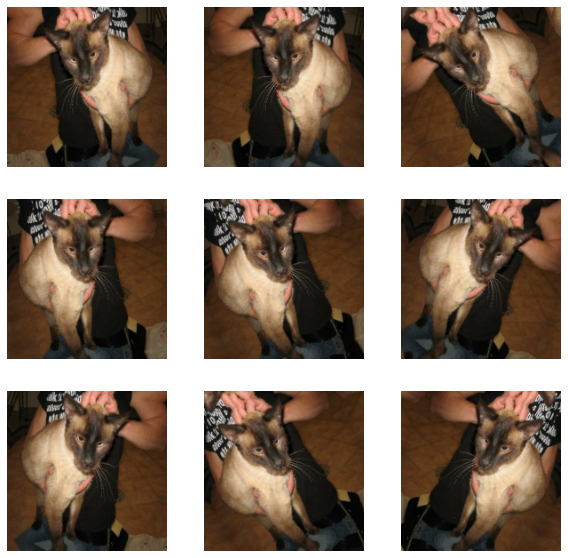

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#Standardizing the data
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model

#Two options to preprocess the data
There are two ways you could be using the data_augmentation preprocessor:

**Option 1: Make it part of the model, like this:**

inputs = keras.Input(shape=input_shape)

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

...  # Rest of the model

In [12]:
#Option 2: apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:

augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [13]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


#Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.


In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.6629

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


586/586 [==============================] - 400s 658ms/step - loss: 0.6217 - accuracy: 0.6629 - val_loss: 0.7412 - val_accuracy: 0.5756
Epoch 2/10
586/586 [==============================] - 383s 653ms/step - loss: 0.4765 - accuracy: 0.7721 - val_loss: 0.4053 - val_accuracy: 0.8185
Epoch 3/10
586/586 [==============================] - 383s 652ms/step - loss: 0.3812 - accuracy: 0.8312 - val_loss: 0.3289 - val_accuracy: 0.8582
Epoch 4/10
586/586 [==============================] - 384s 654ms/step - loss: 0.3214 - accuracy: 0.8622 - val_loss: 0.2944 - val_accuracy: 0.8725
Epoch 5/10
586/586 [==============================] - 383s 652ms/step - loss: 0.2699 - accuracy: 0.8879 - val_loss: 0.6400 - val_accuracy: 0.7379
Epoch 6/10
586/586 [==============================] - 383s 653ms/step - loss: 0.2307 - accuracy: 0.9040 - val_loss: 0.2810 - val_accuracy: 0.8834
Epoch 7/10
586/586 [==============================] - 383s 653ms/step - loss: 0.2097 - accuracy: 0.9107 - val_loss: 0.3061 - val_accura

For 10 ephocs we got ~ 94% accuracy, cal accuracy 83%. For 50 epochs - We will get to ~98% validation accuracy after training  on the full dataset.

#Run inference on new data
Note that data augmentation and dropout are inactive at inference time.

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.76 percent cat and 0.24 percent dog.


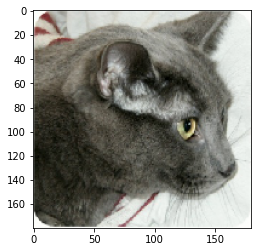

In [ ]:
plt.imshow(img)